In [1]:
# Basic imports for data managing
import pandas as pd
import numpy as np
pd.set_option('display.max.columns', None)

# Ploting imports
import matplotlib.pyplot as plt
import seaborn as sns

# Scaling data
from sklearn.preprocessing import StandardScaler

# Baseline and Metrics
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Classification Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Cross Validation
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_validate
import time

# Warning cleaning
import warnings
warnings.filterwarnings('ignore')

<p style="background-color:#178268; font-family: arial black; color: #FFF9ED; font-size: 300%; text-align: center;">Task 1 - Context</p>

A local bank from Lübeck has hired as data scientist. This department has storaged and aggregating some data of its clients during the past months about their payments and bills to track which ones are doing default payments. They have been manually classifiying who is doing default payments in their credits and trying to forecast based on the data collected which type of profile trends to do it by looking some features. But their prediction has not been accurate enough, so my main job it is do create a machine learning classifier to do this task, which clients are going to do default payments in their credits in the future.

I plan to develop a machine learning classifier using this data to predict whether a client is likely to default on a credit payment. The process will begin with an initial analysis and preprocessing of the data. Once the data is prepared, I will use it to train two commonly used machine learning algorithms and evaluate their performance based on two distinct metrics. To ensure the selection of the most effective classifier, I will perform cross-validation on all models and thoroughly analyze their overall performance. 

The quality criteria for this project are going to be the **recall**, since missing a potential defaulter (false negative) can be very costly for the bank, as it may lead to a financial loss; and the **F1-score**, flagging a non-defaulter as a defaulter (false positive) can harm customer relationships or lead to unnecessary interventions while keeping a balance with the previous measure since it is the combination of recall and precision.

Figuring out which customers might default helps banks cut down on losses, use resources more effectively, stay on good terms with customers, and meet regulatory requirements. Spotting high-risk customers early lets the bank take steps like adjusting credit limits or setting up repayment plans. Meanwhile, not bothering low-risk customers unnecessarily keeps them happier and saves money. In the end, this approach leads to smarter decisions, lower risks, and better profits, all while building trust and loyalty with customers.

<p style="background-color:#178268; font-family: arial black; color: #FFF9ED; font-size: 300%; text-align: center;">Task 2  - The Data</p>

Data Source: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

This dataset is from default payments from bank in Taiwan at the year 2005.

In [2]:
raw_df = pd.read_excel('Default_Credit.xls')
raw_df.columns = raw_df.iloc[0]
raw_df = raw_df[1:]
raw_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
raw_df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object', name=0)

## Features Description

**Output variable (Target)**: default payment next month - Has the client done a default payment next month? (binary: 1 (yes) or 0 (no))

**Client Data:**
- ID: client id inside the database (numeric)
- LIMIT_BAL: Amount of the given credit (in Taiwan dollar (TWD)) given to the account holder (numeric)
- SEX: Gender of the client (binary: 1 = male; 2 = female)
- EDUCATION: (categorical: 1 = graduate school; 2 = university; 3 = high school; 4 = others)
- MARRIAGE: (categorical: 1 = married; 2 = single; 3 = others)
- AGE: (numeric)

**History of past payment**
- PAY_0: the repayment status in September (categorical)
- PAY_2: the repayment status in August (categorical)
- PAY_3: the repayment status in July (categorical)
- PAY_4: the repayment status in June (categorical)
- PAY_5: the repayment status in May (categorical)
- PAY_6: the repayment status in April (categorical)

The measurement scale for the repayment status is: -2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

**Amount of bill statement per month (in TWD)**
- BILL_AMT1: amount of bill statement in September (numeric)
- BILL_AMT2: amount of bill statement in August (numeric)
- BILL_AMT3: amount of bill statement in July (numeric)
- BILL_AMT4: amount of bill statement in June (numeric)
- BILL_AMT5: amount of bill statement in May (numeric)
- BILL_AMT6: amount of bill statement in April (numeric)

**Amount of previous payment (in TWD)**
- PAY_AMT1: amount paid in September (numeric)
- PAY_AMT2: amount paid in August (numeric)
- PAY_AMT3: amount paid in July (numeric)
- PAY_AMT4: amount paid in June (numeric)
- PAY_AMT5: amount paid in May (numeric)
- PAY_AMT6: amount paid in April (numeric)

The dataset suits perfectly for predicting credit payment defaults due to its comprehensive and relevant features. It includes a clear target variable ('default payment next month') and diverse features, such as client demographics, credit limits, payment history, bill amounts, and payment amounts over a six-month period. These features provide good information about clients' financial behavior and payment trends.

<p style="background-color:#178268; font-family: arial black; color: #FFF9ED; font-size: 300%; text-align: center;">Task 3 - IDA</p>

In [4]:
raw_df.shape

(30000, 25)

In [5]:
raw_df.isna().sum()

0
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  object
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  object
 6   PAY_0                       30000 non-null  object
 7   PAY_2                       30000 non-null  object
 8   PAY_3                       30000 non-null  object
 9   PAY_4                       30000 non-null  object
 10  PAY_5                       30000 non-null  object
 11  PAY_6                       30000 non-null  object
 12  BILL_AMT1                   30000 non-null  object
 13  BILL_AMT2                   30000 non-null  ob

- There are no null data type values in the Dataframe. And the shape is 30.000 samples with 25 features.

## Target

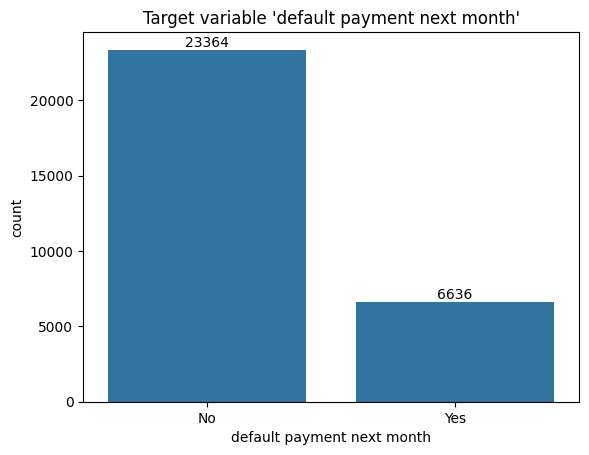

In [7]:
plt.title("Target variable 'default payment next month'")  
plot = sns.countplot(data=raw_df, x='default payment next month')
plot.set_xticklabels(['No', 'Yes'])

for bar in plot.patches:
    plot.annotate(
        format(bar.get_height(), '.0f'),
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center', va='bottom', fontsize=10  # Alignment
    )

plt.show()  # Display the plot

- As we can see, there are around a 77% of the samples that doesn't do a default payment next month. 
- So in the future steps, we will have to take care of the imbalanced data.
- And also maybe we can apply undersampling to improve the performance of the algorithms.

## Client data

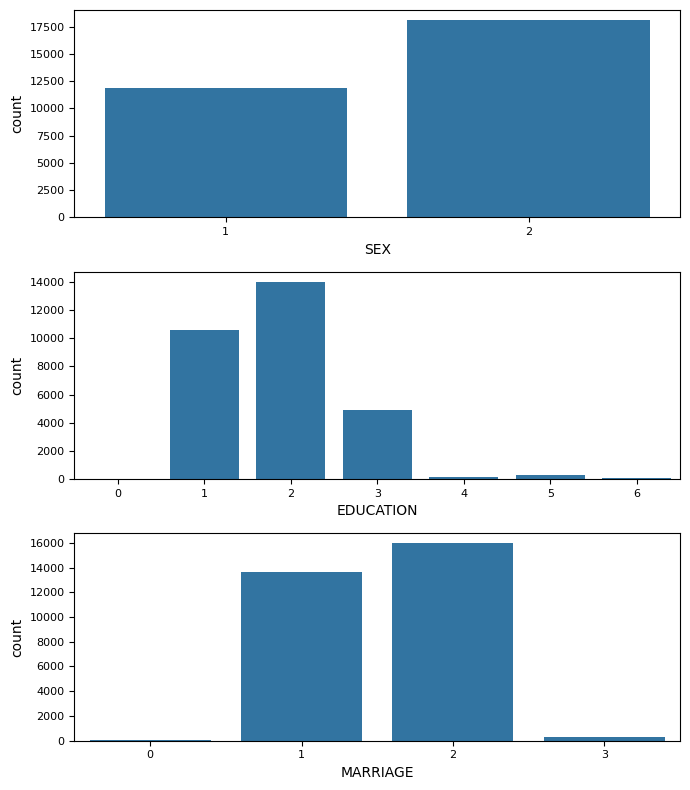

In [8]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
row_idx = 0
idx = 0
fig, ax = plt.subplots(3, 1, figsize=(7, 8))

while row_idx < 3:
    ax[row_idx].tick_params(labelsize=8)
    ax[row_idx].set_xlabel(categorical_features[idx].upper())

    sns.countplot(data=raw_df, x=categorical_features[idx], ax=ax[row_idx])
    row_idx += 1
    idx += 1

fig.tight_layout()

- There are around 5.000 more females in the samples than males.
- And on the other hand, in 'EDUCATION' there are values that is the documentation aren't not included ('0','4','5','6'). And happens the same in 'MARRIAGE' with the value '0'. So in the preprocess step we have to transform this data.

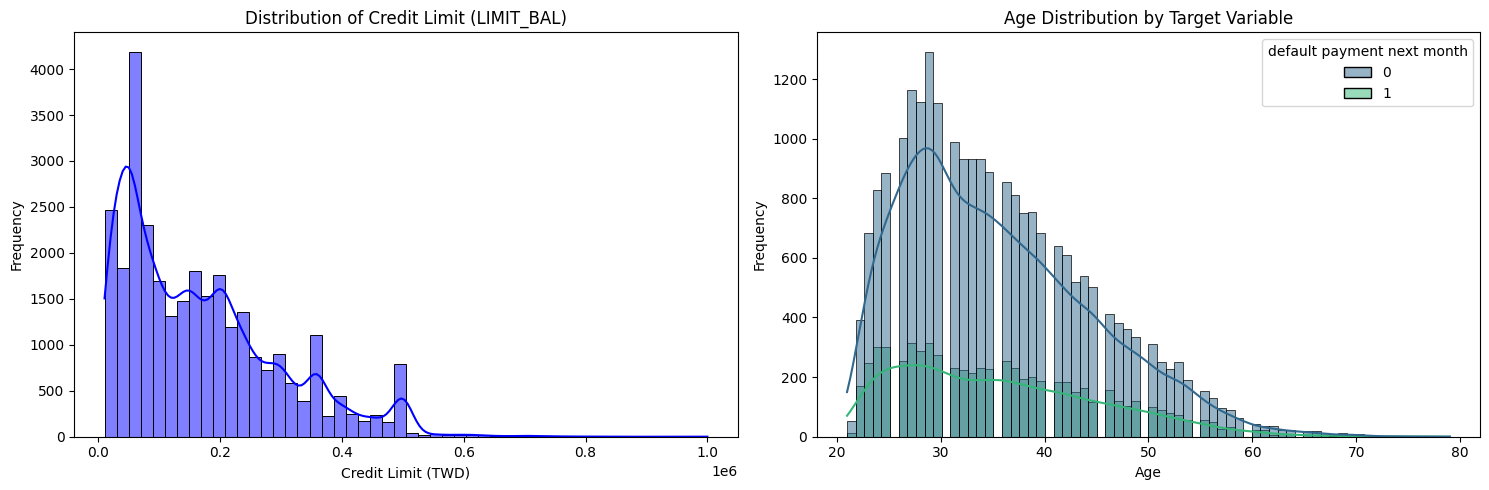

In [9]:
plt.figure(figsize=(15, 5))

# LIMIT_BAL distribution
plt.subplot(1, 2, 1)
sns.histplot(raw_df["LIMIT_BAL"], bins=50, kde=True, color="blue")
plt.title("Distribution of Credit Limit (LIMIT_BAL)")
plt.xlabel("Credit Limit (TWD)")
plt.ylabel("Frequency")

# Age distribution 
plt.subplot(1, 2, 2)
sns.histplot(data=raw_df, x="AGE", hue="default payment next month", kde=True, palette="viridis")
plt.title("Age Distribution by Target Variable")
plt.xlabel("Age")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [10]:
raw_df['LIMIT_BAL'].value_counts().head(5)

LIMIT_BAL
50000     3365
20000     1976
30000     1610
80000     1567
200000    1528
Name: count, dtype: int64

- The age distribution has its peak around 30, showing that most of the samples are around this number.
- Default rates appear higher among younger clients.
- The distribution of the credit's limit has the maximum around 50.000 TWD, with a maximum local around 200.000 TWD. So the quantities referred to some amount of money have a very large range.
- Right-skewed, with most clients having credit limits below 300,000 TWD.

## History of past payment

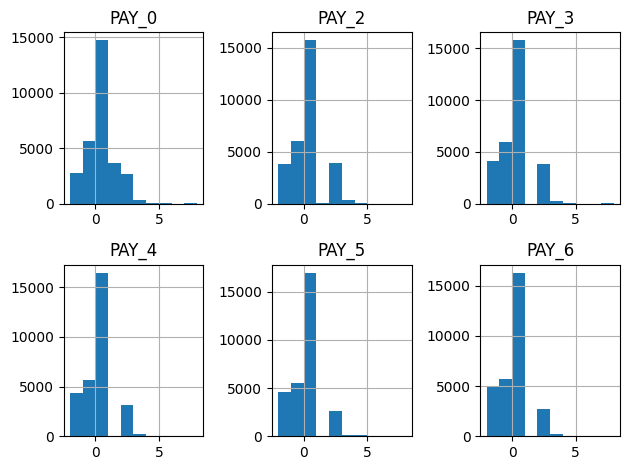

In [11]:
history = raw_df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]

fig=plt.figure()
for i, var_name in enumerate(history.columns):
    ax=fig.add_subplot(2,3,i+1)
    raw_df[var_name].hist(ax=ax)
    ax.set_title(var_name)

fig.tight_layout()

- The value that is most repeated in all months is '0' that shows the use of revolving credit of the customers, followed by '-1' that represents the paid in time with over 5,000 samples and finally the clients that have the credit but don't use it ('-2') with almost 5.000 samples in each month.
- Furthermore, usually the defaulters don't pay with a delay of two months.
- Finally, there is no need to encode these feature since there are already numeric.

## Bill statement and previous payments

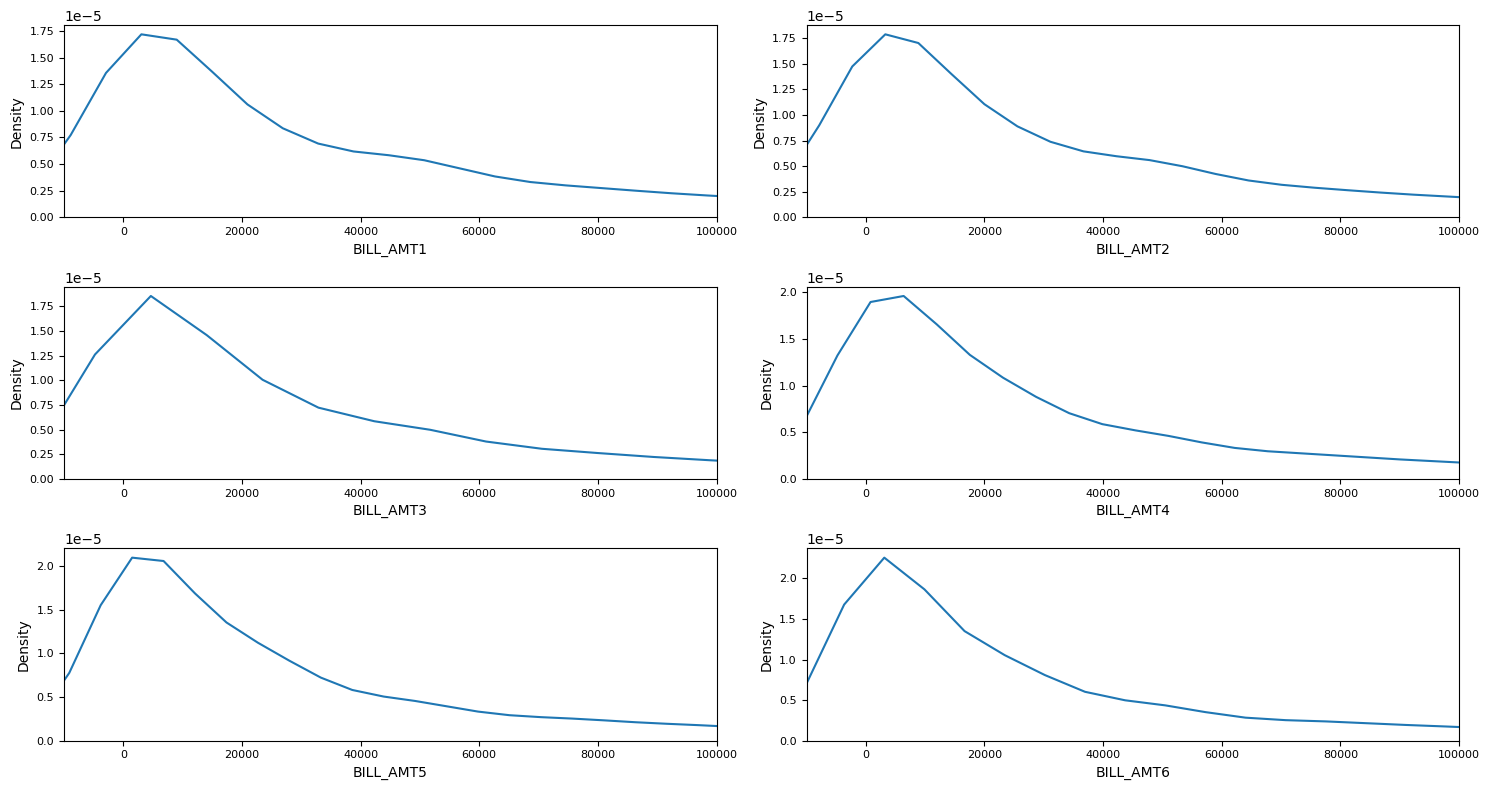

In [12]:
bill_statement = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
row_idx = 0
col_idx = 0
idx = 0

fig, ax = plt.subplots(3, 2, figsize=(15, 8))

for i in range(3):  
    for j in range(2): 
        ax[i, j].tick_params(labelsize=8)
        ax[i, j].set_xlabel(bill_statement[idx])
        ax[i, j].set_xlim(-10000, 100000)
        sns.kdeplot(data=raw_df, x=bill_statement[idx], ax=ax[i, j])
        idx += 1 

fig.tight_layout()

- The most frequent bill amount among the clients and all the months is around the 5.000 TWD with some outliers above the 100.000 TWD
- And the negative values represent clients that at the time of using the revolving credit are surpassing their bills. E.g., the bill of the month is 100€ but the customer pays 250€. Assuming he/she doesn't have other recent purchases, the balance will be -150€ for the bank.

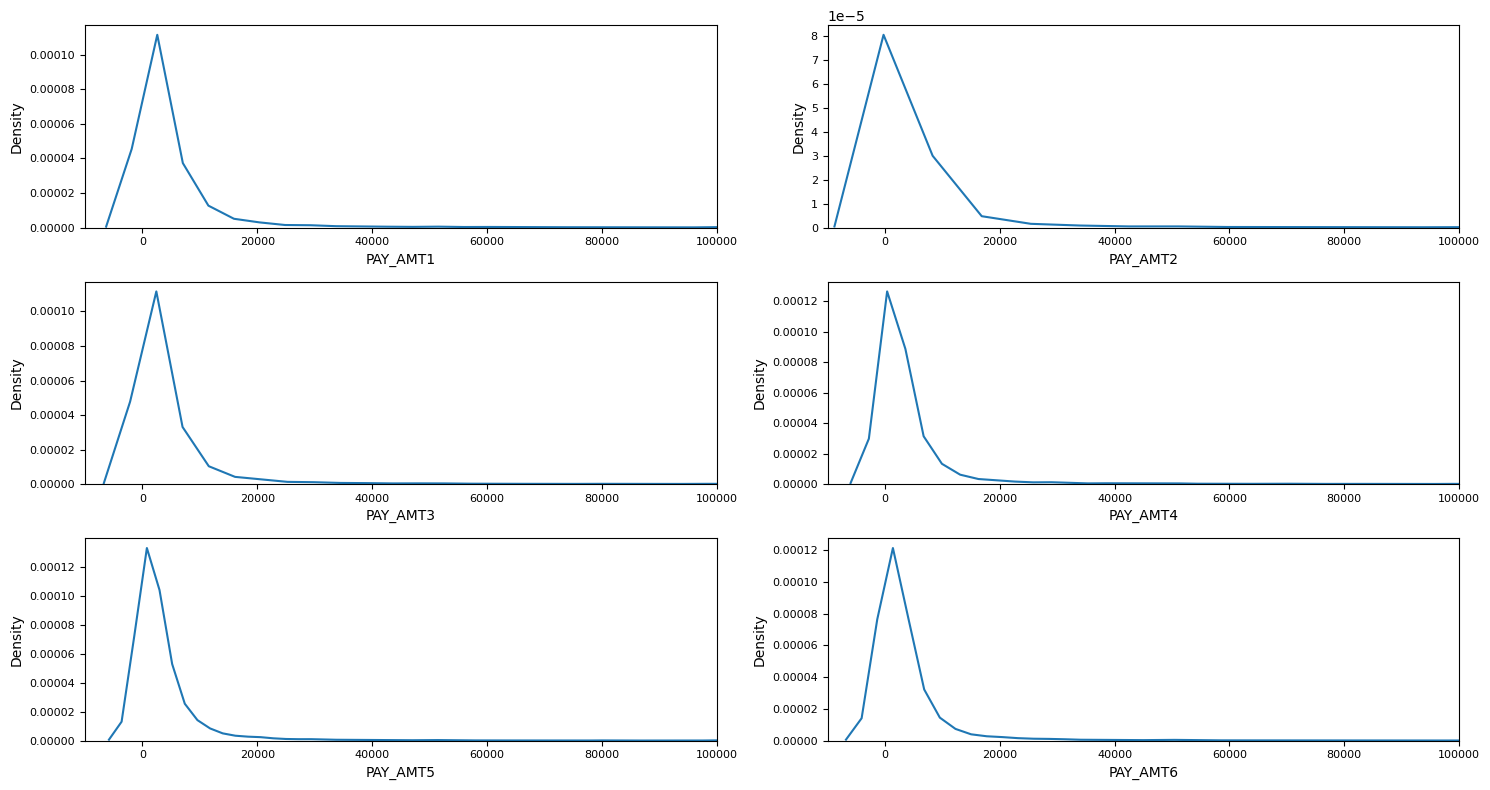

In [13]:
pay_statement = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
row_idx = 0
col_idx = 0
idx = 0

fig, ax = plt.subplots(3, 2, figsize=(15, 8))

for i in range(3):  
    for j in range(2): 
        ax[i, j].tick_params(labelsize=8)
        ax[i, j].set_xlabel(pay_statement[idx])
        ax[i, j].set_xlim(-10000, 100000)
        sns.kdeplot(data=raw_df, x=pay_statement[idx], ax=ax[i, j])
        idx += 1 

fig.tight_layout()

- It happens the same at the bill payments with the negatives values.

<p style="background-color:#178268; font-family: arial black; color: #FFF9ED; font-size: 300%; text-align: center;">Task 4 - EDA & Preprocessing</p>

**Droping the ID column since it doesn't contribute to any insight. And renaming the target column**

In [14]:
raw_df = raw_df.drop(columns='ID')
raw_df = raw_df.rename(columns={'default payment next month': 'target'})

**Renaming columns for a better understanding**

Undersampling should (ideally) be only done to the training data. In the test set, metrics like balanced accuracy can be used to handle the imbalance. <BR>By undersampling the whole dataset, one deviates from the actual usecase. In this particular case, this is maybe ok, as the class distribution in the test set probably is not representative anyways.

In [15]:
dict = {'PAY_0':'PAY_1','BILL_AMT1':'BILL_AMT_1','BILL_AMT2':'BILL_AMT_2','BILL_AMT3':'BILL_AMT_3','BILL_AMT4':'BILL_AMT_4','BILL_AMT5':'BILL_AMT_5','BILL_AMT6':'BILL_AMT_6','PAY_AMT1':'PAY_AMT_1','PAY_AMT2':'PAY_AMT_2', 'PAY_AMT3':'PAY_AMT_3', 'PAY_AMT4':'PAY_AMT_4', 'PAY_AMT5':'PAY_AMT_5', 'PAY_AMT6':'PAY_AMT_6'}
raw_df = raw_df.rename(columns = dict)

As we saw previously, some features have strange values that aren't documented, it happens in 'EDUCATION' ('5','6','0') and in 'MARRIAGE' ('0','3'). But fortunately both features have a category for 'Others'

**Replacing values to the standard ones in the features 'EDUCATION' and 'MARRIAGE'**

In [16]:
raw_df['EDUCATION'] = raw_df['EDUCATION'].replace({5:4,6:4,0:4})
raw_df['MARRIAGE'] = raw_df['MARRIAGE'].replace({0:3})

**Transforming the 'SEX' feature into a real binary one (Male = 1, Female = 0)** Encoding for a better permance of the fiture algorithms.

In [17]:
raw_df['SEX'] = raw_df['SEX'].replace({2:0})

There still is the 6 categorical features of the status payment of each month ,'PAY_N'. But we cannot dumify each of them because that would increase significantly the dimensionality and the model complexity, because there 12 possible categories in each feature and there are 6, so that would increase in +72 the number of attributes. 

So instead of this option, to conserve the properties of these attributes, we are going to create 2 aggregating numerical ones:
- **Max repayment status**: Use the maximum delay across months to capture the worst-case scenario.
Max_PAY=max(PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6)

- **Count of late payments**: Count how many months had a delay (values > 0).

In [18]:
# Calculate MAX_PAY (Maximum delay all months)
raw_df['MAX_PAY'] = raw_df[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].max(axis=1)

# Calculate MONTHS_DELAY_PAY (number of months with delay (value > 0))
raw_df['MONTHS_DELAY_PAY'] = raw_df[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].gt(0).sum(axis=1)

# Drop all the categorical features
raw_df = raw_df.drop(columns=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'])

- **Transforming the feature 'MARRIAGE' as dummy variables.** For the preparation of the machine learning algorithms

In [19]:
# Renaming the column 'MARRIAGE'
raw_df = raw_df.rename(columns={'MARRIAGE':'MARITAL'})

# Changing the values' labels
raw_df['MARITAL'] = raw_df['MARITAL'].replace({1:'MARRIED', 2:'SINGLE', 3:'OTHERS'})

# Dummy variables
raw_df = pd.get_dummies(data = raw_df, columns=['MARITAL'])

raw_df['MARITAL_MARRIED'] = raw_df['MARITAL_MARRIED'].replace({True:1, False:0})
raw_df['MARITAL_SINGLE'] = raw_df['MARITAL_SINGLE'].replace({True:1, False:0})
raw_df['MARITAL_OTHERS'] = raw_df['MARITAL_OTHERS'].replace({True:1, False:0})

raw_df

,LIMIT_BAL,SEX,EDUCATION,AGE,BILL_AMT_1,BILL_AMT_2,BILL_AMT_3,BILL_AMT_4,BILL_AMT_5,BILL_AMT_6,PAY_AMT_1,PAY_AMT_2,PAY_AMT_3,PAY_AMT_4,PAY_AMT_5,PAY_AMT_6,target,MAX_PAY,MONTHS_DELAY_PAY,MARITAL_MARRIED,MARITAL_OTHERS,MARITAL_SINGLE
1,20000,0,2,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,2,2,1,0,0
2,120000,0,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,2,2,0,0,1
3,90000,0,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,0,0,0,1
4,50000,0,2,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0,1,0,0
5,50000,1,2,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,0,0,1,0,0
29997,150000,1,3,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,0,0,0,0,1
29998,30000,1,2,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,4,3,0,0,1
29999,80000,1,3,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,1,1,1,0,0


- **Transforming the feature 'EDUCATION' as dummy variables.** For same reasons mentioned previously.

In [20]:
# Changing the values' labels
raw_df['EDUCATION'] = raw_df['EDUCATION'].replace({1:'GRADUATE_SCHOOL', 2:'UNIVERSITY',3:'HIGH_SCHOOL' ,4:'OTHERS'})
# Dummy variables
raw_df = pd.get_dummies(data = raw_df, columns=['EDUCATION'])

raw_df['EDUCATION_GRADUATE_SCHOOL'] = raw_df['EDUCATION_GRADUATE_SCHOOL'].replace({True:1, False:0})
raw_df['EDUCATION_HIGH_SCHOOL'] = raw_df['EDUCATION_HIGH_SCHOOL'].replace({True:1, False:0})
raw_df['EDUCATION_OTHERS'] = raw_df['EDUCATION_OTHERS'].replace({True:1, False:0})
raw_df['EDUCATION_UNIVERSITY'] = raw_df['EDUCATION_UNIVERSITY'].replace({True:1, False:0})

**Converting the dtypes of the DataFrame to intergers to avoid future problems**

In [21]:
df = raw_df.copy()
df = df.astype(int)

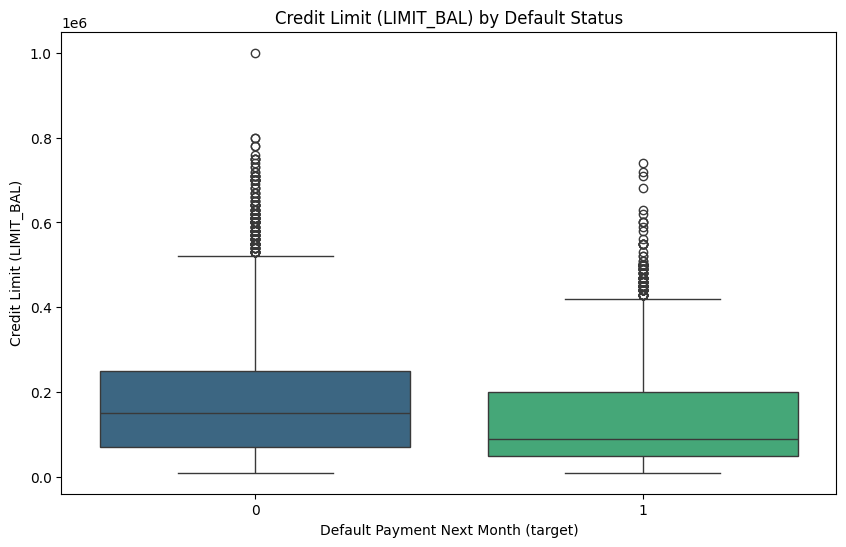

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="target", y="LIMIT_BAL", palette="viridis")
plt.title("Credit Limit (LIMIT_BAL) by Default Status")
plt.xlabel("Default Payment Next Month (target)")
plt.ylabel("Credit Limit (LIMIT_BAL)")
plt.show()

- Clients who defaulted (target = 1) tend to have slightly lower median credit limits than those who did not default.
- Significant overlap between groups, suggesting credit limit alone may not strongly distinguish default risk.
- And a significant quantity of outliers in both values.

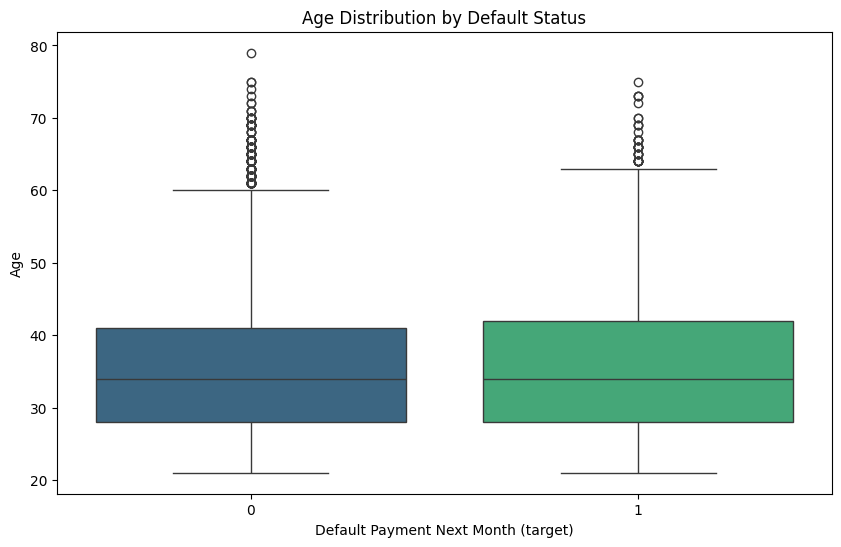

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="target", y="AGE", palette="viridis")
plt.title("Age Distribution by Default Status")
plt.xlabel("Default Payment Next Month (target)")
plt.ylabel("Age")
plt.show()

- Younger clients show higher variance in age distributions among defaulters.
- Median ages are comparable for both defaulters and non-defaulters.

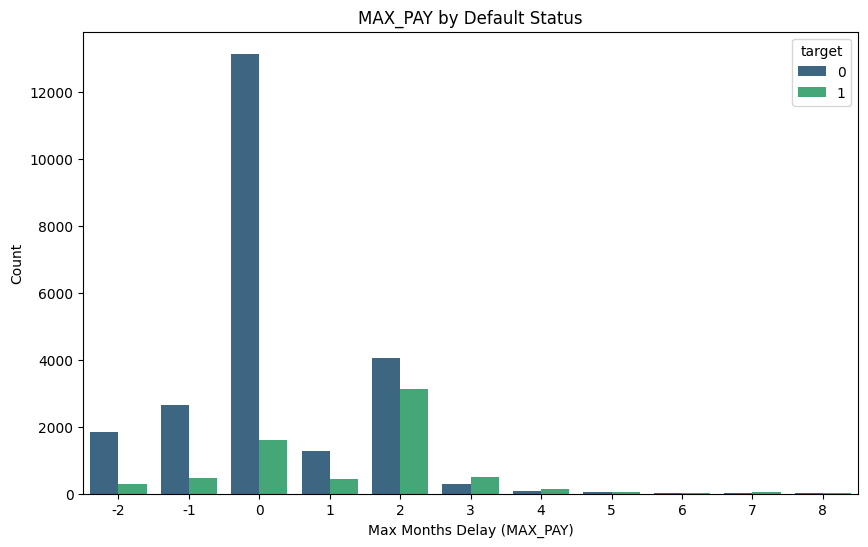

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="MAX_PAY", hue="target", palette="viridis")
plt.title("MAX_PAY by Default Status")
plt.xlabel("Max Months Delay (MAX_PAY)")
plt.ylabel("Count")
plt.show()

- Default rates rise significantly with increasing repayment delays.
- Default is nearly universal for clients with maximum delays starting from 5 months.

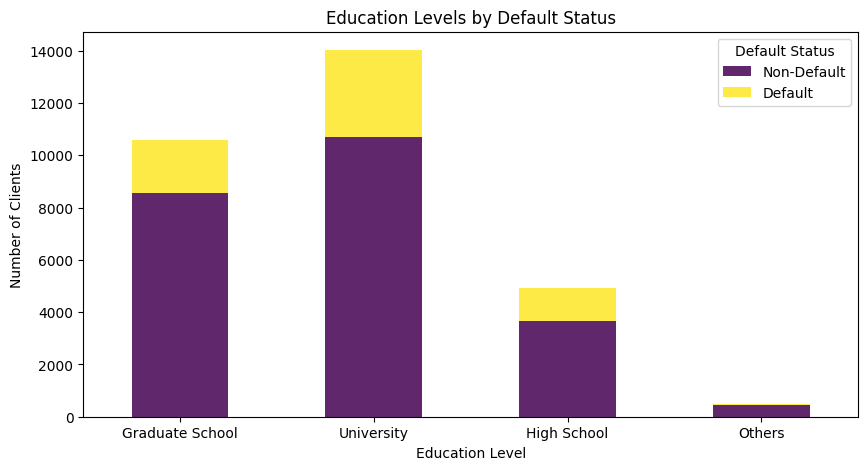

In [25]:
education_columns = ["EDUCATION_GRADUATE_SCHOOL", "EDUCATION_UNIVERSITY","EDUCATION_HIGH_SCHOOL", "EDUCATION_OTHERS"]
education_sums = df.groupby("target")[education_columns].sum().T
education_sums.columns = ["Non-Default", "Default"]
education_sums["Total"] = education_sums.sum(axis=1)

# Plot
education_sums[["Non-Default", "Default"]].plot(kind="bar", stacked=True, figsize=(10, 5), colormap="viridis", alpha=0.85)
plt.title("Education Levels by Default Status")
plt.ylabel("Number of Clients")
plt.xlabel("Education Level")
plt.xticks(range(len(education_columns)), ["Graduate School", "University", "High School", "Others"], rotation=360)
plt.legend(title="Default Status")
plt.show()

- Clients with University education form the largest group and have a significant proportion of defaults, followed by Graduate School.
- In proportion, University group has the most number of defaults and the others has the least proportion of defaulters.

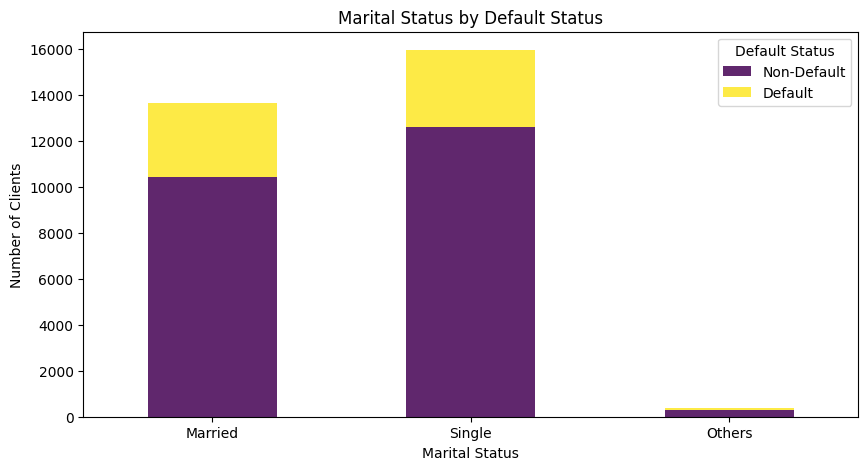

In [26]:
# 4. Marital Status vs. Default Status
marital_columns = ["MARITAL_MARRIED", "MARITAL_SINGLE", "MARITAL_OTHERS"]
marital_sums = df.groupby("target")[marital_columns].sum().T
marital_sums.columns = ["Non-Default", "Default"]
marital_sums["Total"] = marital_sums.sum(axis=1)

# Plot marital status distribution
marital_sums[["Non-Default", "Default"]].plot(kind="bar", stacked=True, figsize=(10, 5), colormap="viridis",alpha=0.85)
plt.title("Marital Status by Default Status")
plt.ylabel("Number of Clients")
plt.xlabel("Marital Status")
plt.xticks(range(len(marital_columns)), ["Married", "Single", "Others"], rotation = 360)
plt.legend(title="Default Status")
plt.show()

- Both the number of defaulters and non-defaulters are greater compared to other marital statuses.
- Others has an insignificant number of clients and defaults.

**Separating the target and the independent features into variables X and y**

In [27]:
y = df['target']
X = df.drop(labels='target', axis = 1)

**Scaling the features**

In [28]:
scaler =  StandardScaler()
X_scaled_arr = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_arr,columns=X.columns)
X_scaled.head()

,LIMIT_BAL,SEX,AGE,BILL_AMT_1,BILL_AMT_2,BILL_AMT_3,BILL_AMT_4,BILL_AMT_5,BILL_AMT_6,PAY_AMT_1,PAY_AMT_2,PAY_AMT_3,PAY_AMT_4,PAY_AMT_5,PAY_AMT_6,MAX_PAY,MONTHS_DELAY_PAY,MARITAL_MARRIED,MARITAL_OTHERS,MARITAL_SINGLE,EDUCATION_GRADUATE_SCHOOL,EDUCATION_HIGH_SCHOOL,EDUCATION_OTHERS,EDUCATION_UNIVERSITY
0,-1.136720,-0.810161,-1.246020,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1.160679,0.750059,1.093780,-0.112812,-1.066471,-0.738375,-0.442752,-0.125886,1.0669
1,-0.365981,-0.810161,-1.029047,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1.160679,0.750059,-0.914261,-0.112812,0.937672,-0.738375,-0.442752,-0.125886,1.0669
2,-0.597202,-0.810161,-0.161156,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,-0.326164,-0.536713,-0.914261,-0.112812,0.937672,-0.738375,-0.442752,-0.125886,1.0669
3,-0.905498,-0.810161,0.164303,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,-0.326164,-0.536713,1.093780,-0.112812,-1.066471,-0.738375,-0.442752,-0.125886,1.0669
4,-0.905498,1.234323,2.334029,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,-0.326164,-0.536713,1.093780,-0.112812,-1.066471,-0.738375,-0.442752,-0.125886,1.0669


In [29]:
X_scaled.shape, y.shape

((30000, 24), (30000,))

**Finally, we have 24 features with 30.000 samples and a target after the preprocessing**

<p style="background-color:#178268; font-family: arial black; color: #FFF9ED; font-size: 300%; text-align: center;">Task 5.1 - Baseline</p>

**Splitting the data with test size = 30%**, it will be the same for all the algorithms.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 1, shuffle=True, stratify=y)

**Choosing Uniform Classifier as a baseline model**

In [31]:
baseline_model = DummyClassifier(strategy="uniform", random_state=1)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

In [32]:
print("Baseline Most Frequent model\n{}\n".format(classification_report(y_test, y_pred)))

Baseline Most Frequent model
              precision    recall  f1-score   support

           0       0.78      0.50      0.61      7009
           1       0.22      0.49      0.30      1991

    accuracy                           0.50      9000
   macro avg       0.50      0.50      0.46      9000
weighted avg       0.65      0.50      0.54      9000




But as we have mentioned previously, the data is imbalanced, there are more values of not getting in default (0) that getting it (1). 

So we are **Undersampling the data to make variables 50-50%**, to improve the performance of algorithms in the further steps

In [33]:
undersampler = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [34]:
baseline_model = DummyClassifier(strategy="uniform", random_state=1)
baseline_model.fit(X_resampled, y_resampled)
y_pred = baseline_model.predict(X_test)

In [35]:
print("Baseline Uniform model  (undersampled data):\n{}\n".format(classification_report(y_test, y_pred)))

Baseline Uniform model  (undersampled data):
              precision    recall  f1-score   support

           0       0.78      0.50      0.61      7009
           1       0.22      0.49      0.30      1991

    accuracy                           0.50      9000
   macro avg       0.50      0.50      0.46      9000
weighted avg       0.65      0.50      0.54      9000




**Note:** I haven't chosen the 'most_frequent' in this scenario because the recall would have been 0 in the value '1' and it wouldn't have been an accurate and honest baseline.

**Baseline (No trained model)**
- Class '0' (Not getting into default payment): 
    - F1 = 0.61
    - Recall = 0.50
- Class '1' (Getting into default payment):
    - Precision = 0.30
    - Recall = 0.49

- The f1-score of value '1' is quite low and also the recall of label '0' could be improved.

<p style="background-color:#178268; font-family: arial black; color: #FFF9ED; font-size: 300%; text-align: center;">Task 5.2 - Algorithms</p>

In [36]:
def f1_recall_results(model, XTrain, yTrain, XTest, ytest):
    """
        The function has as inputs a model, training and test data, 
        trains the model with the XTrain and yTrain,
        and returns an array with the f1-score and recall results on the XTest.
    """
    model.fit(XTrain,yTrain)
    y_pred = model.predict(XTest)
    f1 = f1_score(ytest, y_pred, average='macro')
    recall = recall_score(ytest, y_pred, average='macro')

    return [f1, recall]

## KNN

**Hyperparameters**
- The hyperparameters to optimize are k and the decision rule
- Hyperparameters fixed are:
    - The distance (Default -> Minkowski)
    - As previously said, the training data (it is going to be fixed for all the algorithms at 30%)

**Transformations on the dataset**
- In this case we have applied the scaling beforehand because features with larger ranges dominate the calculations, making the model biased. <br>
With Standardization  all features are brought to the same scale, ensuring equal contribution to distance measurements.

In [37]:
# Start the DataFrames of the results
results_f1_uniform = pd.DataFrame(columns=['k','f1'])
results_f1_distance = pd.DataFrame(columns=['k','f1'])
results_recall_uniform = pd.DataFrame(columns=['k','recall'])
results_recall_distance = pd.DataFrame(columns=['k','recall'])

In [38]:
# Loop for testing the KNN with 'Uniform' decision rule with 1 to 100 neighbors
for k in range(1,101):

    #UNIFORM DECISION RULE
    knn_uniform = KNeighborsClassifier(weights='uniform', n_neighbors=k)
    results = f1_recall_results(knn_uniform, X_resampled, y_resampled, X_test, y_test)
    f1_result = results[0]
    recall_result = results[1]

    # New row of f1-UNIFORM
    f1_row = {'k':k, 'f1': f1_result}
    results_f1_uniform.loc[len(results_f1_uniform)] = f1_row

    # New row of recall-UNIFORM
    recall_row = {'k':k, 'recall': recall_result}
    results_recall_uniform.loc[len(results_recall_uniform)] = recall_row

In [39]:
# Loop for testing the KNN with 'Distance' decision rule with 1 to 100 neighbors
for k in range(1,101):

    # DISTANCE DECISION RULE
    knn_distance = KNeighborsClassifier(weights='distance', n_neighbors=k)
    results = f1_recall_results(knn_distance, X_resampled,y_resampled,X_test,y_test)
    f1_result = results[0]
    recall_result = results[1]

    # New row of f1-UNIFORM
    f1_row = {'k':k, 'f1': f1_result}
    results_f1_distance.loc[len(results_f1_distance)] = f1_row

    # New row of recall-UNIFORM
    recall_row = {'k':k, 'recall': recall_result}
    results_recall_distance.loc[len(results_recall_distance)] = recall_row

In [40]:
# Merging both DataFrames of Recall
results_recall_distance['rule'] = 'distance'
results_recall_uniform['rule'] = 'uniform'
results_recall_knn = pd.concat([results_recall_uniform,results_recall_distance], ignore_index = True)

# Merging both DataFrames of F1
results_f1_distance['rule'] = 'distance'
results_f1_uniform['rule'] = 'uniform'
results_f1_knn = pd.concat([results_f1_uniform,results_f1_distance], ignore_index = True)

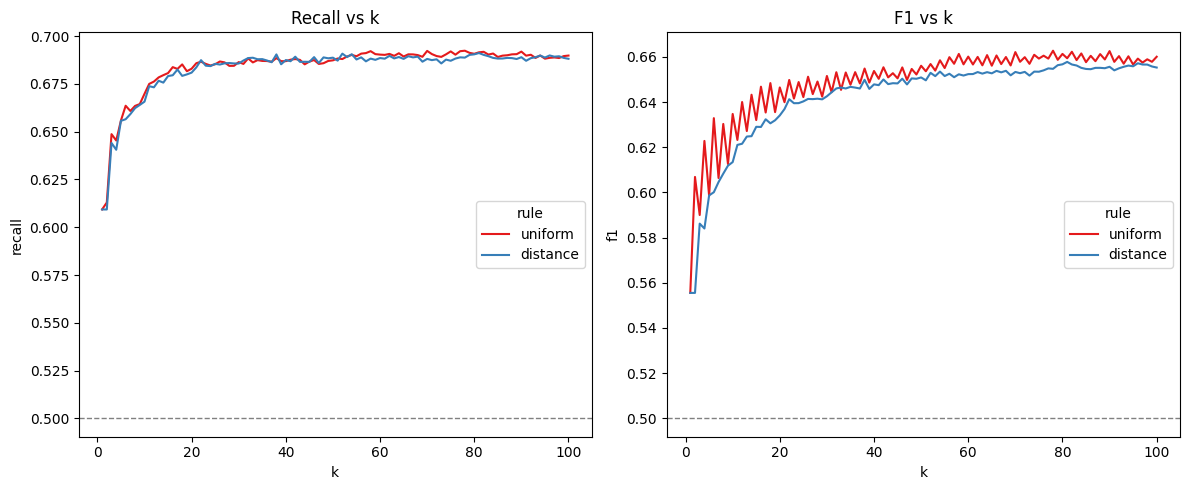

In [41]:
plt.figure(figsize=(12, 5))

# Plot of Recall
plt.subplot(1, 2, 1)
plt.title('Recall vs k')
sns.lineplot(data=results_recall_knn, x='k', y='recall', hue='rule', palette='Set1')
plt.axhline(0.50, color='gray', linestyle='--', linewidth=1) # Baseline

# Plot of F1
plt.subplot(1, 2, 2)
plt.title('F1 vs k')
sns.lineplot(data=results_f1_knn, x='k', y='f1', hue='rule', palette='Set1')
plt.axhline(0.50, color='gray', linestyle='--', linewidth=1)  # Baseline

plt.tight_layout()
plt.show()

In [42]:
# Searching for the optimize setting of hyperparameters
top_recall = [results_recall_uniform['recall'].idxmax() , results_recall_uniform['recall'].max()]
top_F1 = [results_f1_uniform['f1'].idxmax(), results_f1_uniform['f1'].max()]

print(f'Max recall (Uniform) at k = {top_recall[0]} with a value of {top_recall[1]}')
print(f'Max F1-Score (Uniform) at k = {top_F1[0]} with a value of {top_F1[1]}')

Max recall (Uniform) at k = 77 with a value of 0.6923569029673335
Max F1-Score (Uniform) at k = 77 with a value of 0.6627616475836768


**Performance of KNN with different values of hyperparamaters**

- The decision rule 'Uniform' in this case performs better than the 'Distance'.
- It surpasses the previous baseline of 0.5 at both quality measures, but there is still margin for improvement
- And the suitable N_Neighbors (k) should be 77 with 'Uniform' for the later cross validation. since it is the best performance.


### Learning curve - KNN

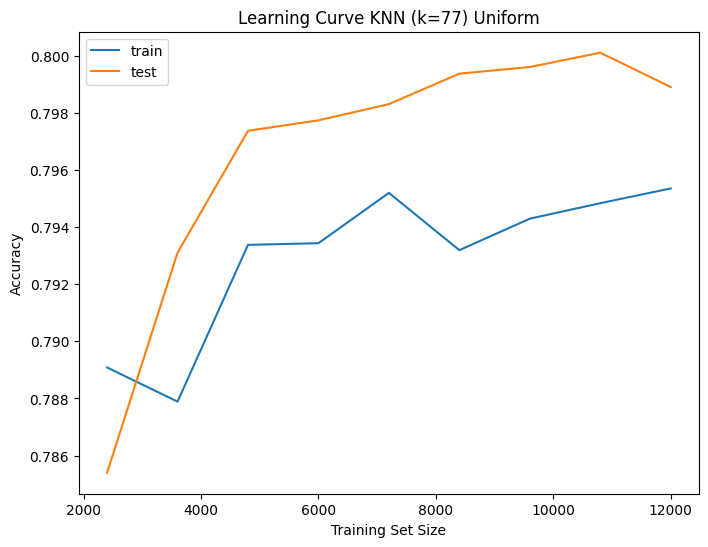

In [43]:
knn_uniform = KNeighborsClassifier(weights='uniform', n_neighbors=77)
train_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
train_sizes, train_scores, test_scores = learning_curve(estimator= knn_uniform, 
                                                        X = X_scaled, y = y, 
                                                        train_sizes=train_sizes,
                                                        scoring = 'accuracy',
                                                        random_state=1)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="test")

plt.title("Learning Curve KNN (k=77) Uniform")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.show()

- The testing accuracy consistently surpasses the training accuracy for most of the dataset sizes. This could occur because the KNN model is regularized by the choice of k=77, which averages predictions over many neighbors and reduces overfitting.
- Increasing the training data improves test accuracy significantly up to a point, but the gain diminishes with further increases.
- The test accuracy reaches its maximum at around 0.8 but starts to slightly decline after the largest training sizes, maybe because of the additional training data or potential effects of noise in the data.

## Decision tree

**Hyperparameters** 
- The hyperparameters to optimize are 'max_depth' and the Cost-Complexity Pruning alpha ('ccp_alpha')
- Hyperparameters fixed are:
    - Information Gain (Default -> Gini), since it has the least computational cost.
    - As previously said, the training data (it is going to be fixed for all the algorithms at 30%)

**Transformations on the dataset**
- Decision trees don’t require scaled data because they make decisions based on thresholds of the features, and these comparisons are independent of the magnitude or scale of the data. <br> However, you can use a scaled dataset without affecting its performance, as the relationships between the data remain intact. So we are going to use the scaled data also.

In [44]:
# Start the DataFrames of the results
results_f1_tree = pd.DataFrame(columns=['max_depth','f1_score'])
results_recall_tree= pd.DataFrame(columns=['max_depth','recall_score'])

In [45]:
# Loop for testing the DecisionTree from a range pf 3 to 40 'max_depth'
for k in range(3, 41):

    tree_classifier = DecisionTreeClassifier(max_depth= k, random_state=1, criterion='gini')
    results = f1_recall_results(tree_classifier, X_resampled, y_resampled, X_test, y_test)
    f1_result = results[0]
    recall_result = results[1]

    # New row on results F1
    f1_row = pd.DataFrame({'max_depth': [k], 'f1_score':[f1_result]})
    results_f1_tree = pd.concat([results_f1_tree, f1_row], ignore_index=True)

    # New row on results Recall
    recall_row = pd.DataFrame({'max_depth':[k], 'recall_score':[recall_result]})
    results_recall_tree = pd.concat([results_recall_tree, recall_row], ignore_index=True)

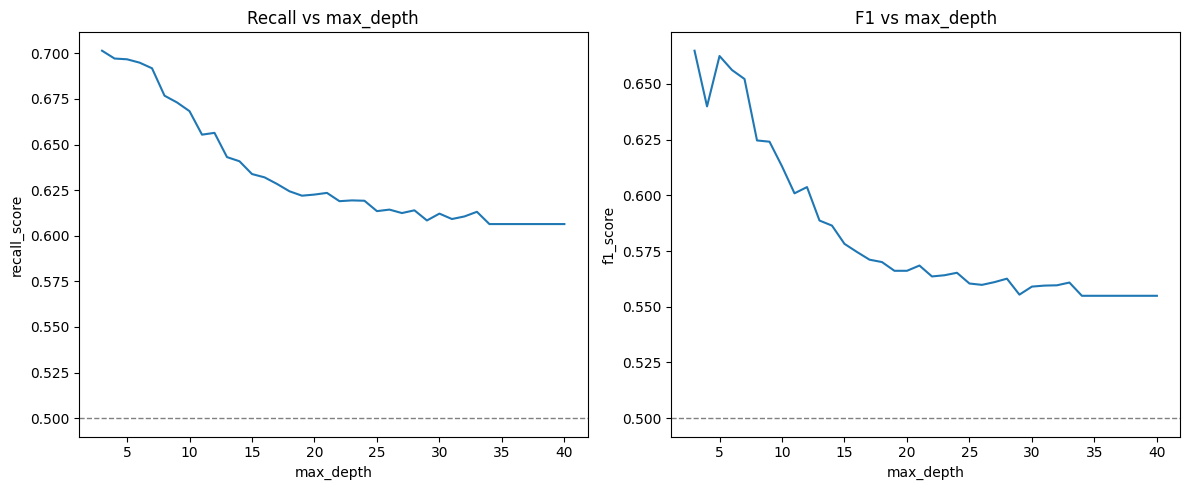

In [46]:
plt.figure(figsize=(12, 5))

# Plot of Recall
plt.subplot(1, 2, 1)
plt.title('Recall vs max_depth')
sns.lineplot(data=results_recall_tree, x='max_depth', y='recall_score', palette='Set1')
plt.axhline(0.50, color='gray', linestyle='--', linewidth=1)  

# Plot of F1
plt.subplot(1, 2, 2)
plt.title('F1 vs max_depth')
sns.lineplot(data=results_f1_tree, x='max_depth', y='f1_score', palette='Set1')
plt.axhline(0.50, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [47]:
# Searching for the optimize setting of hyperparameters
top_recall = [results_recall_tree['recall_score'].idxmax()+3, results_recall_tree['recall_score'].max()]
top_f1 = [results_f1_tree['f1_score'].idxmax()+3, results_f1_tree['f1_score'].max()]

print(f'Max recall (Tree Classifier) at max_depth = {top_recall[0]} with a value of {top_recall[1]}')
print(f'Max F1 (Tree Classifier) at max_depth = {top_f1[0]} with a value of {top_f1[1]}')

Max recall (Tree Classifier) at max_depth = 3 with a value of 0.7014382168753541
Max F1 (Tree Classifier) at max_depth = 3 with a value of 0.6649082951552451


- Highest recall is achieved at a maximum depth of 3, with a value of 0.701
- Similarly, the highest f1 is obtained at a maximum depth of 3, with a value of 0.665
- As the depth of the tree increases, both recall and f1 show a consistent decline, suggesting that deeper trees might be overfitting and losing generalization.
- A small depth achieves relatively higher recall, as it creates simpler decision boundaries that prioritize general patterns rather than overfitting to the majority class.
- But, the baseline is surpass it at all the depths.

In [48]:
# Range of ccp_alpha
ccp_alpha = np.arange(0,0.1,0.0025).tolist()

# Start the DataFrames of the results
results_f1_tree = pd.DataFrame(columns=['alpha','f1_score'])
results_recall_tree= pd.DataFrame(columns=['alpha','recall_score'])

In [49]:
# Loop for testing the DecisionTree from a range of ccp_alpha
for k in ccp_alpha:

    tree_classifier = DecisionTreeClassifier(ccp_alpha= k, random_state=1, criterion='gini')
    results = f1_recall_results(tree_classifier, X_resampled, y_resampled, X_test, y_test)
    f1_result = results[0]
    recall_result = results[1]

    # New row on results F1-score
    f1_row = pd.DataFrame({'alpha': [k], 'f1_score':[f1_result]})
    results_f1_tree = pd.concat([results_f1_tree, f1_row], ignore_index=True)

    # New row on results Recall
    recall_row = pd.DataFrame({'alpha':[k], 'recall_score':[recall_result]})
    results_recall_tree = pd.concat([results_recall_tree, recall_row], ignore_index=True)

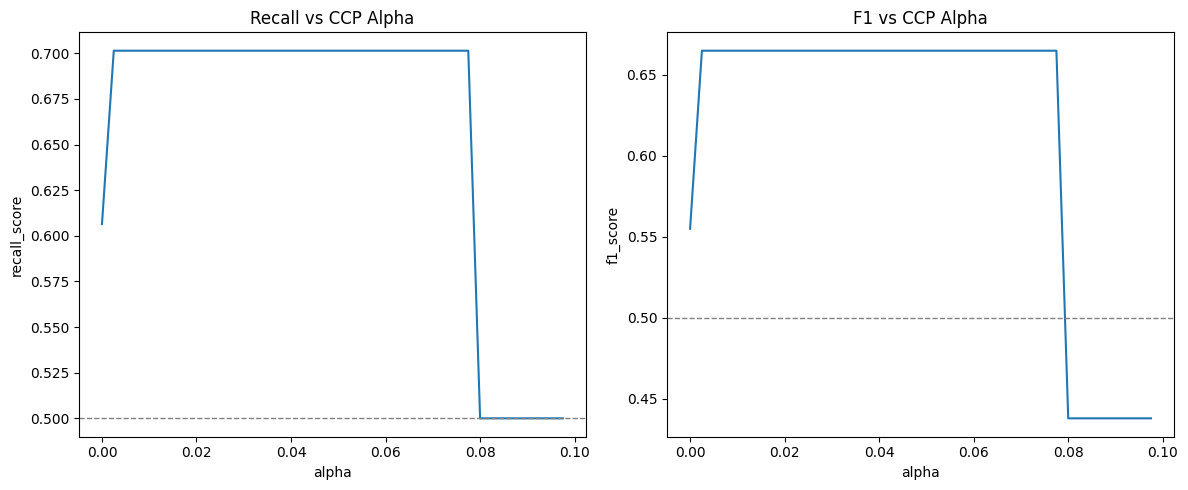

In [50]:
plt.figure(figsize=(12, 5))

# Plot of Recall
plt.subplot(1, 2, 1)
plt.title('Recall vs CCP Alpha')
sns.lineplot(data=results_recall_tree, x='alpha', y='recall_score', palette='Set1')
plt.axhline(0.50, color='gray', linestyle='--', linewidth=1)  

# Plot of F1
plt.subplot(1, 2, 2)
plt.title('F1 vs CCP Alpha')
sns.lineplot(data=results_f1_tree, x='alpha', y='f1_score', palette='Set1')
plt.axhline(0.50, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [51]:
top_recall = [results_recall_tree['alpha'][results_recall_tree['recall_score'].idxmax()], results_recall_tree['recall_score'].max()]
top_f1 = [results_f1_tree['alpha'][results_f1_tree['f1_score'].idxmax()], results_f1_tree['f1_score'].max()]

print(f'Max recall (Tree Classifier) with a CCP Alpha = {top_recall[0]} with a value of {top_recall[1]}')
print(f'Max F1 (Tree Classifier) with a CCP Alpha = {top_f1[0]} with a value of {top_f1[1]}')

Max recall (Tree Classifier) with a CCP Alpha = 0.0025 with a value of 0.7014382168753541
Max F1 (Tree Classifier) with a CCP Alpha = 0.0025 with a value of 0.6649082951552451


- The highest recall and f1 are achieved at a CCP Alpha value of 0.0025.
- The recall score at this point is approximately 0.7, and the f1 score is approximately 0.67.
- Both recall and f1 remain stable for lower values of CCP Alpha, but they drop sharply after CCP Alpha exceeds around 0.08. <br>This suggests that using a CCP Alpha value beyond this threshold significantly reduces model performance.

### Learnin Curve - Decision Tree

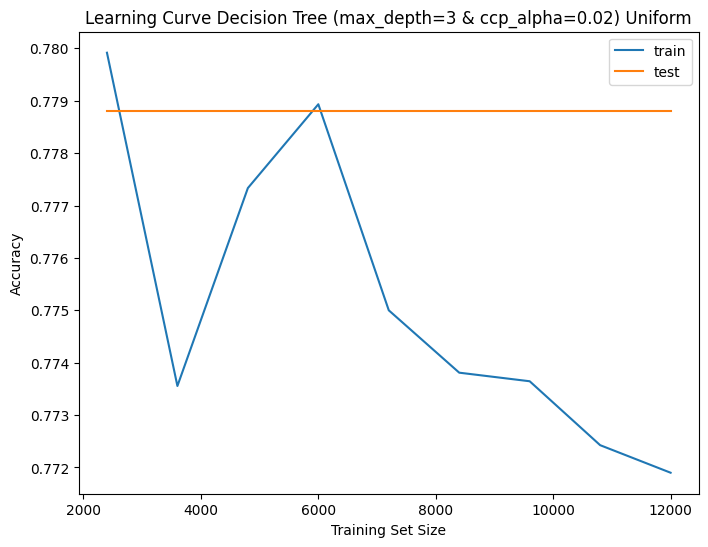

In [52]:
decision_tree = DecisionTreeClassifier(ccp_alpha=0.02, max_depth=3)
train_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
train_sizes, train_scores, test_scores = learning_curve(estimator= decision_tree, 
                                                        X = X_scaled, y = y, 
                                                        train_sizes=train_sizes,
                                                        scoring = 'accuracy',
                                                        random_state=1)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="test")

plt.title("Learning Curve Decision Tree (max_depth=3 & ccp_alpha=0.02) Uniform")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.show()

- The flatter test curve indicates that this tree provides robust generalization but sacrifices the ability to model complex patterns as the training set size grows.
- Considering that the the accuracy varies between 0.78 and 0.772, there is not much to interprete. It is likely due to the variation in the random variation of selected data.

<p style="background-color:#178268; font-family: arial black; color: #FFF9ED; font-size: 300%; text-align: center;">Task 6 - Nested Cross Validation</p>

In [53]:
# Number of trials for nested cv
NUM_TRIALS = 3
# Number of times cv to be repeated.
NUM_INNER_REPEATS = 3
# Number of splits in inner cv
NUM_INNER_SPLITS = 10 
# Number of splits in outer cv
NUM_OUTER_SPLITS = 10
# Performance Metrics
PERF_METRICS = ['precision','recall','f1']
# Metrics for the comparing all algorithms (columns for the future DataFrame)
METRICS = ['name','recall_min','recall_max','recall_mean','recall_std','precision_min','precision_max','precision_mean','precision_std','f1_min','f1_max','f1_mean','f1_std','fit_time(avg)','test_time(avg)']

In [54]:
# Reference from the machine learning lescture
def nested_cv(estimator, grid_params, x, y):
    """
       Function with inputs: machine learning model, grid of parameters for the model, features and target variables.
       Inner and outer cv are run using the machine learning model and are evaluated on different metrics and parameters 
       Function returns performance results
    """
    f1 = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    recall = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    precision = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    test_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    start = time.time()

    for i in range(NUM_TRIALS):
        print("Running Outer CV in iteration: ", i, " at ", time.time()-start, "s")
        # inner cv
        inner_cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=i)
        # outer cv
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i)

        # Refit on  recall because is the quality measures
        model = GridSearchCV(estimator=estimator, param_grid=grid_params, cv=inner_cv, scoring=PERF_METRICS, n_jobs=-1, refit="recall")
        model_results = cross_validate(model, X=x, y=y, cv=outer_cv, scoring=PERF_METRICS, n_jobs=-1)
    
        precision[i] = model_results["test_precision"]
        f1[i] = model_results["test_f1"]
        recall[i] = model_results["test_recall"]
        fit_times[i]=model_results['fit_time']
        test_times[i]=model_results['score_time']
    
    print ("Total time: ", (time.time()-start),  "s")
    return  precision, recall, f1, fit_times, test_times

In [55]:
def concatenate_metrics (df, name, precision,  f1, recall, fit_times, test_time):
    """
    Function to concate all the results of the algorithms into one single DataFrame for a future comparison
    """
    data = [name, recall.min(),recall.max(),recall.mean(),recall.std(), precision.min(), precision.max(), precision.mean(), precision.std(), f1.min(),f1.max(),f1.mean(),f1.std(), fit_times.mean(),test_time.mean()]
    new_dataframe = pd.DataFrame(data=[data],columns=METRICS)
    
    return pd.concat([df, new_dataframe], ignore_index=True, axis=0)

In [56]:
# Starting the DataFrame for results
df_nested_cv_results = pd.DataFrame(columns=METRICS)

## Nested CV - KNN

Based on the previous results the grid for the hyperparameter of the Nested CV of KNN is:
- **Decision Rule**: 'Uniform'
- **NºNeighbors**: Range between 60 to 80

In [57]:
# Setting of hyperparameter's grid
grid_params = {"weights":['uniform'],"n_neighbors": range(60,81)}

# Starting of Nested Cross Validation
knn = KNeighborsClassifier()
precision, f1, recall, fit_times, test_times = nested_cv(knn, grid_params, X_resampled, y_resampled)
df_nested_cv_results = concatenate_metrics(df_nested_cv_results, "KNN", precision, f1, recall, fit_times, test_times)

Running Outer CV in iteration:  0  at  0.0 s
Running Outer CV in iteration:  1  at  210.78541660308838 s
Running Outer CV in iteration:  2  at  418.77382946014404 s
Total time:  624.2862017154694 s


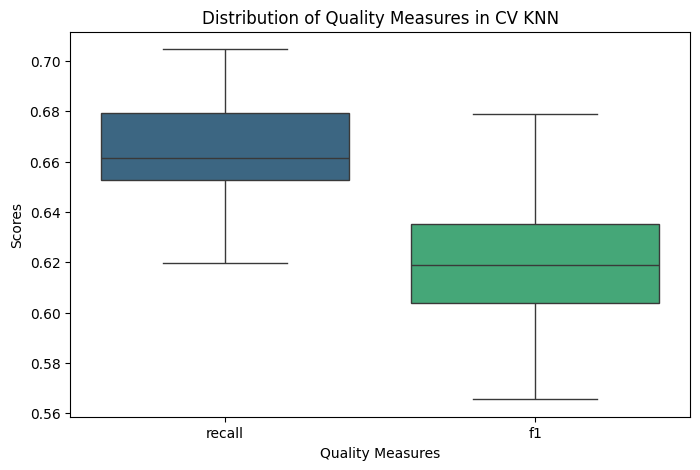

In [58]:
# Array to DataFrame of the test performance during the outer cross validation
# Recall
recall = recall.flatten()
recall = pd.DataFrame(recall, columns=['score'])
recall['measure'] = 'recall'
# F1
f1 = f1.flatten()
f1 = pd.DataFrame(f1, columns=['score'])
f1['measure'] = 'f1'
#Merging both DF into one single
measures_results = pd.concat([recall, f1], ignore_index=True, axis=0)
measures_results
# Ploting
plt.figure(figsize=(8, 5))
sns.boxplot(data=measures_results, x="measure", y="score", palette="viridis")
plt.title("Distribution of Quality Measures in CV KNN")
plt.xlabel("Quality Measures")
plt.ylabel("Scores")
plt.show()

- In the recall has the median around 0.66, with a smaller spread, indicating the model consistently identifies positive cases.
- But the f1-score, it is slightly lower (median around 0.62), suggesting some inconsistency in balancing precision and recall across folds.
- The model is reliable for detecting positives but not a good with the precision-recall balance (F1).

In [59]:
# Gathering all results into one DataFrame
df_nested_cv_results

,name,recall_min,recall_max,recall_mean,recall_std,precision_min,precision_max,precision_mean,precision_std,f1_min,f1_max,f1_mean,f1_std,fit_time(avg),test_time(avg)
0,KNN,0.619552,0.704698,0.664198,0.019594,0.674528,0.764075,0.718301,0.020388,0.565591,0.678879,0.618162,0.025596,203.951784,0.666735


## Nested CV - Decision Tree

Based on the previous results the grid for the hyperparameter of the Nested CV of Decision Tree is:
- **Max_Depth**: Range between 3 and 10
- **CCP Alpha**: Range between 0.1 to 0.08

In [60]:
# Setting of hyperparameter's grid
grid_params = {'max_depth':np.arange(3,11), 'ccp_alpha':np.arange(0.01,0.08,0.01)}

# Starting of Nested Cross Validation
decision_tree = DecisionTreeClassifier()
precision, f1, recall, fit_times, test_times = nested_cv(decision_tree, grid_params, X_resampled, y_resampled)
df_nested_cv_results = concatenate_metrics(df_nested_cv_results, "Decision Tree", precision, f1, recall, fit_times, test_times)

Running Outer CV in iteration:  0  at  0.0 s
Running Outer CV in iteration:  1  at  314.42603945732117 s
Running Outer CV in iteration:  2  at  644.626091003418 s
Total time:  963.5905764102936 s


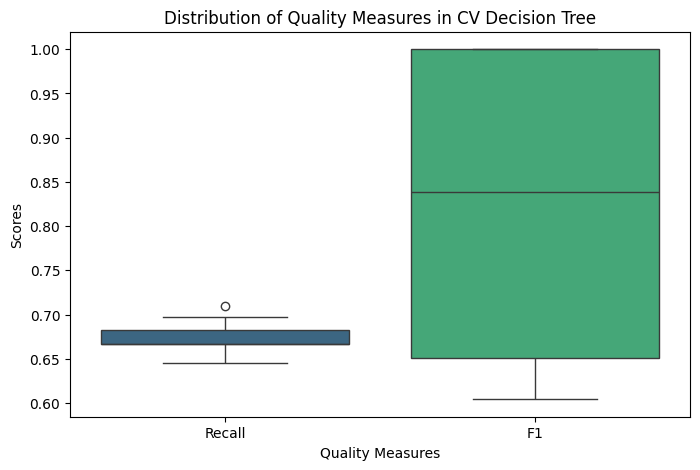

In [61]:
# Array to DataFrame of the test performance during the outer cross validation
# Recall
recall = recall.flatten()
recall = pd.DataFrame(recall, columns=['score'])
recall['measure'] = 'Recall'
# F1
f1 = f1.flatten()
f1 = pd.DataFrame(f1, columns=['score'])
f1['measure'] = 'F1'
#Merging both DF into one single
measures_results = pd.concat([recall, f1], ignore_index=True, axis=0)
measures_results

# Ploting
plt.figure(figsize=(8, 5))
sns.boxplot(data=measures_results, x="measure", y="score", palette="viridis")
plt.title("Distribution of Quality Measures in CV Decision Tree")
plt.xlabel("Quality Measures")
plt.ylabel("Scores")
plt.show()

- The recall has a narrow range (0.65-0.71), indicating that the identification of positive cases is stable across folds.
- The F1-score's median is around 0.85, but with a huge range (0.6-1.0) and high variability, suggesting inconsistent performance in balancing precision and recall.

In [62]:
# Gathering all results into one DataFrame
df_nested_cv_results

,name,recall_min,recall_max,recall_mean,recall_std,precision_min,precision_max,precision_mean,precision_std,f1_min,f1_max,f1_mean,f1_std,fit_time(avg),test_time(avg)
0,KNN,0.619552,0.704698,0.664198,0.019594,0.674528,0.764075,0.718301,0.020388,0.565591,0.678879,0.618162,0.025596,203.951784,0.666735
1,Decision Tree,0.645455,0.709459,0.672497,0.013681,0.499462,0.744681,0.607068,0.108163,0.604301,1.000000,0.823369,0.177429,319.877664,0.039646


## Nested CV - Baseline

In [63]:
def baseline_cv (estimator, x, y):
    """
    Function similar to the previous one but for baseline Cross-Validation
    """
    precision = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    f1 = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    recall = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times= np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    test_times=np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    start = time.time()

    for i in range(NUM_TRIALS):
        print("Running Outer CV in iteration: ", i, " at ", time.time()-start, "s")
        # outer cv
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i)
        model_results = cross_validate(estimator, X=x, y=y, cv=outer_cv, scoring=PERF_METRICS, n_jobs=-1)
    
        precision[i] = model_results["test_precision"]
        f1[i] = model_results["test_f1"]
        recall[i] = model_results["test_recall"]
        fit_times[i]=model_results['fit_time']
        test_times[i]=model_results['score_time']
    
    print ("Total time: ", (time.time()-start),  "s")
    return  precision, recall, f1, fit_times, test_times

In [64]:
# Starting of Nested Cross Validation
baseline = DummyClassifier(strategy="uniform", random_state=1)
precision, f1, recall, fit_times, test_times = baseline_cv(baseline, X_resampled, y_resampled)
nested_cv_results_df = concatenate_metrics(df_nested_cv_results, "Uniform Classifier (baseline)", precision,f1, recall, fit_times, test_times)

Running Outer CV in iteration:  0  at  0.0 s
Running Outer CV in iteration:  1  at  0.19488048553466797 s
Running Outer CV in iteration:  2  at  0.36232829093933105 s
Total time:  0.5539765357971191 s


In [65]:
# Gathering all results into one DataFrame
nested_cv_results_df

,name,recall_min,recall_max,recall_mean,recall_std,precision_min,precision_max,precision_mean,precision_std,f1_min,f1_max,f1_mean,f1_std,fit_time(avg),test_time(avg)
0,KNN,0.619552,0.704698,0.664198,0.019594,0.674528,0.764075,0.718301,2.038813e-02,0.565591,0.678879,0.618162,0.025596,203.951784,0.666735
1,Decision Tree,0.645455,0.709459,0.672497,0.013681,0.499462,0.744681,0.607068,1.081629e-01,0.604301,1.000000,0.823369,0.177429,319.877664,0.039646
2,Uniform Classifier (baseline),0.478595,0.479121,0.478858,0.000263,0.488789,0.488789,0.488789,5.551115e-17,0.468817,0.469828,0.469322,0.000505,0.007412,0.013132


## Interpretation of the Nested CV Results

- **KNN**: It has a moderate recall and f1-score means, 0.664 and 0.618 respectively. And KNN performs decently across both metrics but shows slightly lower F1-Score compared to the Decision Tree.
- **Decision Tree**: It outperforms KNN and the baseline in F1-Score significantly with a mean of 0.82, indicating better precision-recall balance. And the recall is slightly higher than KNN as well.
- **Baseline**: The performance of the baseline model is lower on every metrics compared to other 2 algorithms.

## Discussion

- Both of the algorithms performs better than the Uniform Baseline in f1 and recall metrics.

- And Decision Tree has the highest **F1-score mean** (0.823), which indicates it strikes the best balance between precision and recall. <br> It is true that it has a big desviation of 0.177, but in the worst scenario it has a **f1_min** of 0.604 that is very close to KNN's **f1_mean** (0.618).

- On the other hand, on the **recall** metric, the Decision Tree surpass the **recall_mean** of the KNN (0.672497 > 0.664), <br> but in the worst scenario (**recall_min**) happpens the contrary, the KNN beats the Decision Tree with a huge gap (0.674>0.499)

- Moreover, since we mentioned previously on the Decision Tree sacrifices the ability to model complex patterns as the training set size grows. But it is quite scalable and efficient.

- So this reasons, the final model for the task it is going to be the **Decision Tree**.

## Optimize Hyperparameters

In [66]:
def train_prod_model(estimator, grid, features, targets):
    """_summary_
    Function to extract the best combinations of hyperparamters of a model.
    It returns the best combination of hyperparameters that are inputs in the function (grid)
    """
    NUM_INNER_REPEAT = 10
    NUM_INNER_SPLITS = 10

    cv = RepeatedStratifiedKFold(n_splits = NUM_INNER_SPLITS,
                                 n_repeats = NUM_INNER_REPEAT,
                                 random_state = 1)
    clf = GridSearchCV(estimator = estimator,
                       param_grid = grid,
                       cv = cv,
                       n_jobs = -1)
    clf.fit(features, targets)
    print(clf.best_params_)

    return clf

In [67]:
md_tree_grid = {'max_depth':np.arange(3,11), 'ccp_alpha':np.arange(0.01,0.08,0.01)}
clf = train_prod_model(DecisionTreeClassifier(random_state = 1), md_tree_grid, X_resampled, y_resampled)

{'ccp_alpha': np.float64(0.01), 'max_depth': np.int64(3)}


- So the final model it is the Decision Tree:
    - 'max_depth' = 3
    - 'ccp_alpha' = 0.01

<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 7 - Analysis of the Final Model</p>

Evaluating Fold 1/10...
Evaluating Fold 2/10...
Evaluating Fold 3/10...
Evaluating Fold 4/10...
Evaluating Fold 5/10...
Evaluating Fold 6/10...
Evaluating Fold 7/10...
Evaluating Fold 8/10...
Evaluating Fold 9/10...
Evaluating Fold 10/10...

Combined Classification Report Across Folds:

              precision    recall  f1-score     support
0              0.675579  0.748108  0.709780  464.500000
1              0.717354  0.639807  0.676037  464.500000
accuracy       0.693972  0.693972  0.693972    0.693972
macro avg      0.696467  0.693957  0.692908  929.000000
weighted avg   0.696462  0.693972  0.692914  929.000000


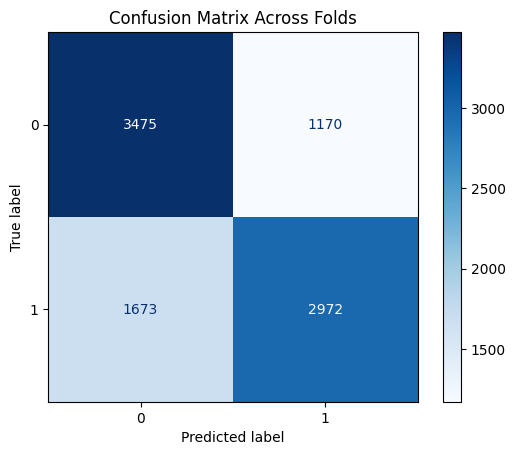

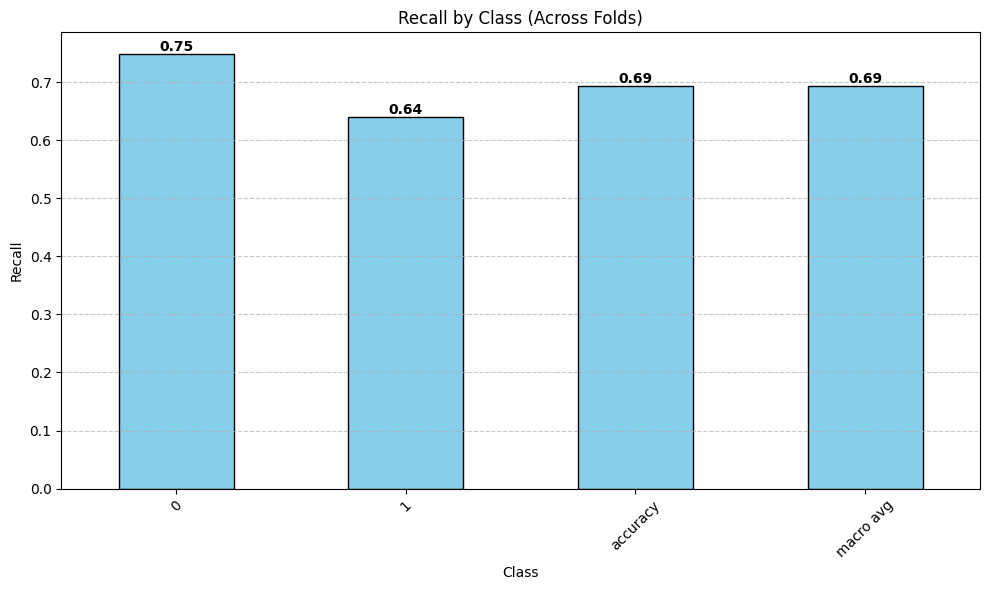

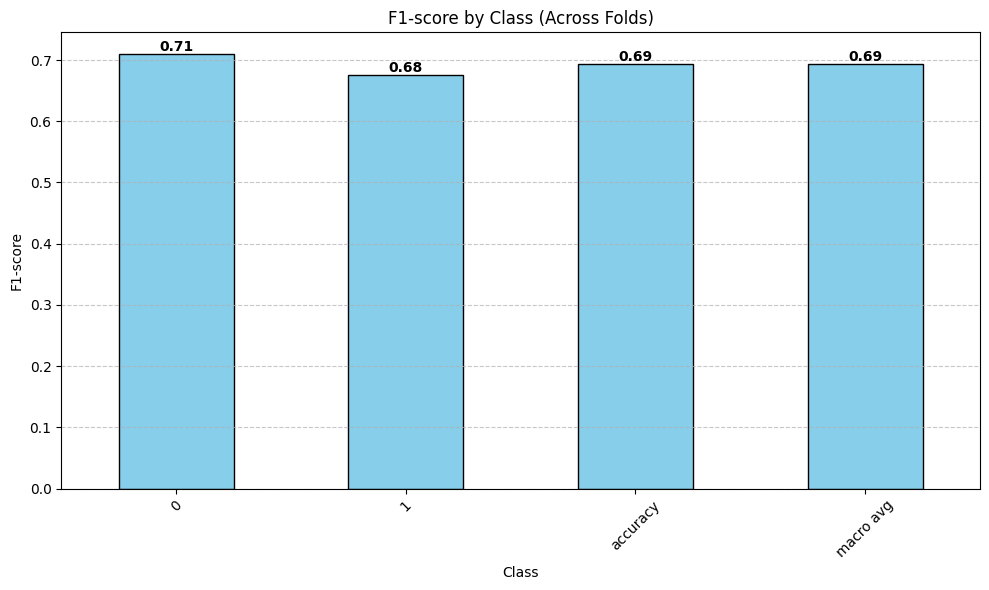

In [68]:
def analyze_final_model_classification(model, X, y, n_splits=10):
    """
    Evaluate the final classification model using outer cross-validation.
    Analyze and visualize the performance on individual classes.
    
    Parameters:
    - model: The classification model to evaluate.
    - X: Features (numpy array or pandas DataFrame).
    - y: Target labels (numpy array or pandas Series).
    - n_splits: Number of cross-validation folds.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_reports = []
    y_true_all = []
    y_pred_all = []

    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"Evaluating Fold {fold}/{n_splits}...")
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Store true and predicted values for combined evaluation
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
        # Classification report for each fold
        report = classification_report(y_test, y_pred, output_dict=True)
        fold_reports.append(pd.DataFrame(report).transpose())

    # Combine results across folds
    combined_report = pd.concat(fold_reports, axis=0).groupby(level=0).mean()

    # Generate visualizations
    print("\nCombined Classification Report Across Folds:\n")
    print(combined_report)

    # Confusion Matrix
    cm = confusion_matrix(y_true_all, y_pred_all, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix Across Folds")
    plt.show()

    # Per-class performance visualizations
    metrics = ['recall', 'f1-score']
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        bars = combined_report[metric].iloc[:-1].plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"{metric.capitalize()} by Class (Across Folds)")
        plt.ylabel(metric.capitalize())
        plt.xlabel("Class")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels on top of the bars
        for bar in bars.patches:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                     ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# Evaluate the final model
analyze_final_model_classification(DecisionTreeClassifier(max_depth=3, ccp_alpha=0.01, random_state=1), X_resampled, y_resampled, n_splits=10)

## Confusion Matrix
- True Negatives (TN) -> 3475 customers correctly predicted as non-defaulters next month
- False Positives (FP) -> 1170 customers wrongly predicted as defaulters next month
- True Postives (TP) -> 1673 defaulters correctly predicted
- False negatives (FN) -> 1673 defaulters not predicted

Recall = TP / (TP + FN) ≈ 64

**While 64% recall for defaulters is decent, there’s still room for improvement as missing 1673 defaulters could have significant financial implications.**

## Recall by Class

Recall across folds indicates that the model performs better in identifying non-defaulters (class 0 = 75%) compared to defaulters (class 1 = 64%)

The imbalance in recall suggests the model might be slightly biased toward the majority class (non-defaulters). <br> Given the higher cost associated with missing defaulters, the model should be fine-tuned to prioritize class 1 recall, even at the expense of slightly lower precision for class 0.

## F1-Score by Class

The F1-score balances precision and recall, and the values across classes are consistent a little more consistent than the recall (72% and 66% repectively)

While these scores indicate solid overall performance, further steps could improve the F1-score for class 1 to ensure both precision and recall are better balanced for defaulters.

<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 8 - Conclusions and Future Work</p>

**Summary and Interpretation**
- When running the KNN and Decision Tree algorithms, both outperformed the baseline provided by the Uniform Classifier across all performance metrics. For the problem of forecasting possible default payments, the Decision Tree showed slightly better performance in terms of recall_mean compared to KNN (0.67 > 0.66). Additionally, it achieved a much better balance between precision and recall, with an F1-score of 0.82, which significantly surpasses that of KNN (0.61). Although the recall exceeded the baseline threshold, it remains insufficient for practical implementation, as the recall stands at 64%, leaving a notable percentage of defaulters incorrectly predicted.

- Regarding the F1-score, while it outperformed the baseline, the results still fall short of the 80–85% range, which would be a more acceptable safety margin for reliable forecasting.

**Generated Value**
- This machine learning forecast provides a rough and automated estimate of potential defaulters for the upcoming month. This creates value by saving time and offering an initial approximation of next month’s earnings. However, the model's performance is still too limited to be fully dependable.

**Future work**
- Test XGBoost: XGBoost is well-suited for datasets with a high complexity of features and large volumes of data. Since each tree is trained to correct the errors of the previous ones by minimizing the gradient of the loss function, this algorithm could better capture the complex patterns in our dataset.

- Combine classifier outputs with business rules: Enhance decision-making by integrating model outputs with expert input or business rules, particularly for borderline cases.

- Fine-tune the decision threshold: Adjust the decision threshold to prioritize recall for class 1 (defaulters). While this may increase false positives slightly, it is acceptable given the context of the project.

**Criticism**
- Efforts were made to reduce complexity by creating new features that captured the properties of the original ones, to avoid significantly increasing model complexity. However, this may be the main reason why the max_depth parameter is too constrained, preventing the model from exploring deeper, more complex patterns.

- While using the UnderSampler from sklearn to balance the y forecast, only the default option ('auto') was utilized. A higher ratio for the defaulter label (1) could have been explored to potentially improve performance.

- Outliers likely exist in the dataset, particularly in the LIMIT_BAL feature, as observed during the EDA and IDA tasks. These outliers should be addressed.

- Due to the General Data Protection Regulation (GDPR) and the Federal Data Protection Act, the sex feature is highly sensitive. It should be excluded from the analysis unless it is strictly necessary.

- Overall, the project delivered good results but falls short of being suitable for direct real-world implementation. Testing more than two algorithms is recommended to provide a broader comparative analysis.